# Importando o que importa (haha)

In [39]:
from freeSpace import *
from collections import defaultdict
import numpy as np
import math
import pandas as pd
from geopy.distance import vincenty
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Pegando os Valores de Treinamento

In [40]:
#Erbs
csvErbs = pd.read_csv("erbs.csv")
erbsLidas = csvErbs[['lat','lon']].values
erbs_posicao = dict()
for i in range (1,len(erbsLidas)+1):
    erbs_posicao[i] = (erbsLidas[i-1])

#Medicoes, dados de treinamento
csvMed = pd.read_csv("medicoes.csv")
#testMed = pd.read_csv("testLoc.csv")
#csvMed = pd.concat([csvMed, testMed])
medidas_posicao = csvMed[['lat','lon']].values # Valores em Tupla
medidas_potencia = csvMed[["RSSI_1","RSSI_2","RSSI_3","RSSI_4","RSSI_5","RSSI_6"]].values

#Distancias em Kilometros de cada Medição em relação a cada ERB
distanciasFS = defaultdict(list)
for erbNum in range(1,7):
    distanciasFS[erbNum] = []
    for coord in medidas_posicao:
        distanciasFS[erbNum].append(vincenty(coord,erbs_posicao[erbNum]).kilometers)

# Analisando os Valores de Treinamento

In [41]:
#Valores
X = csvMed['lat'].values
Y = csvMed['lon'].values
Z = csvMed["RSSI_1"].values

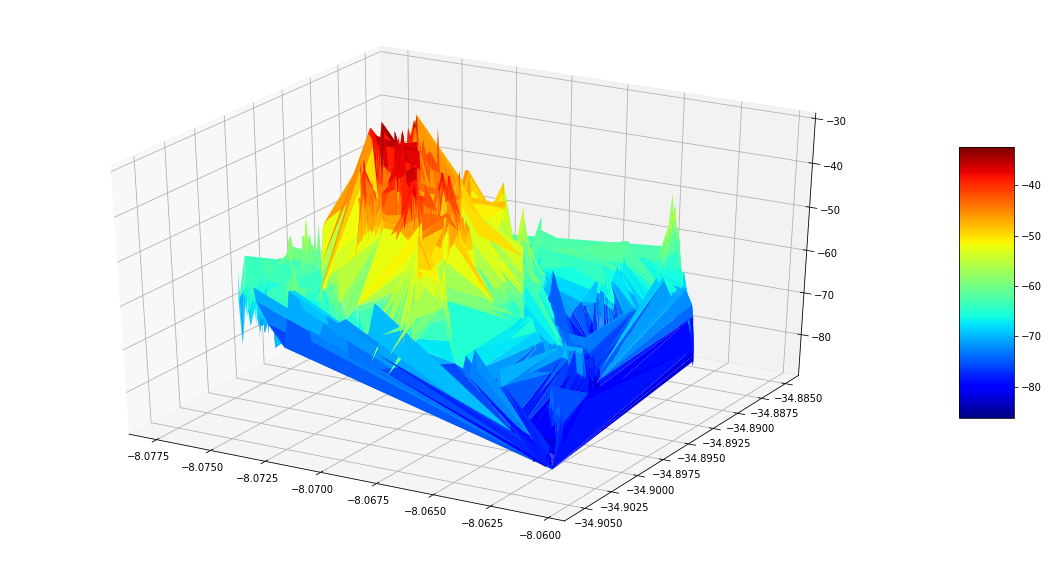

In [42]:
plt.clf()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

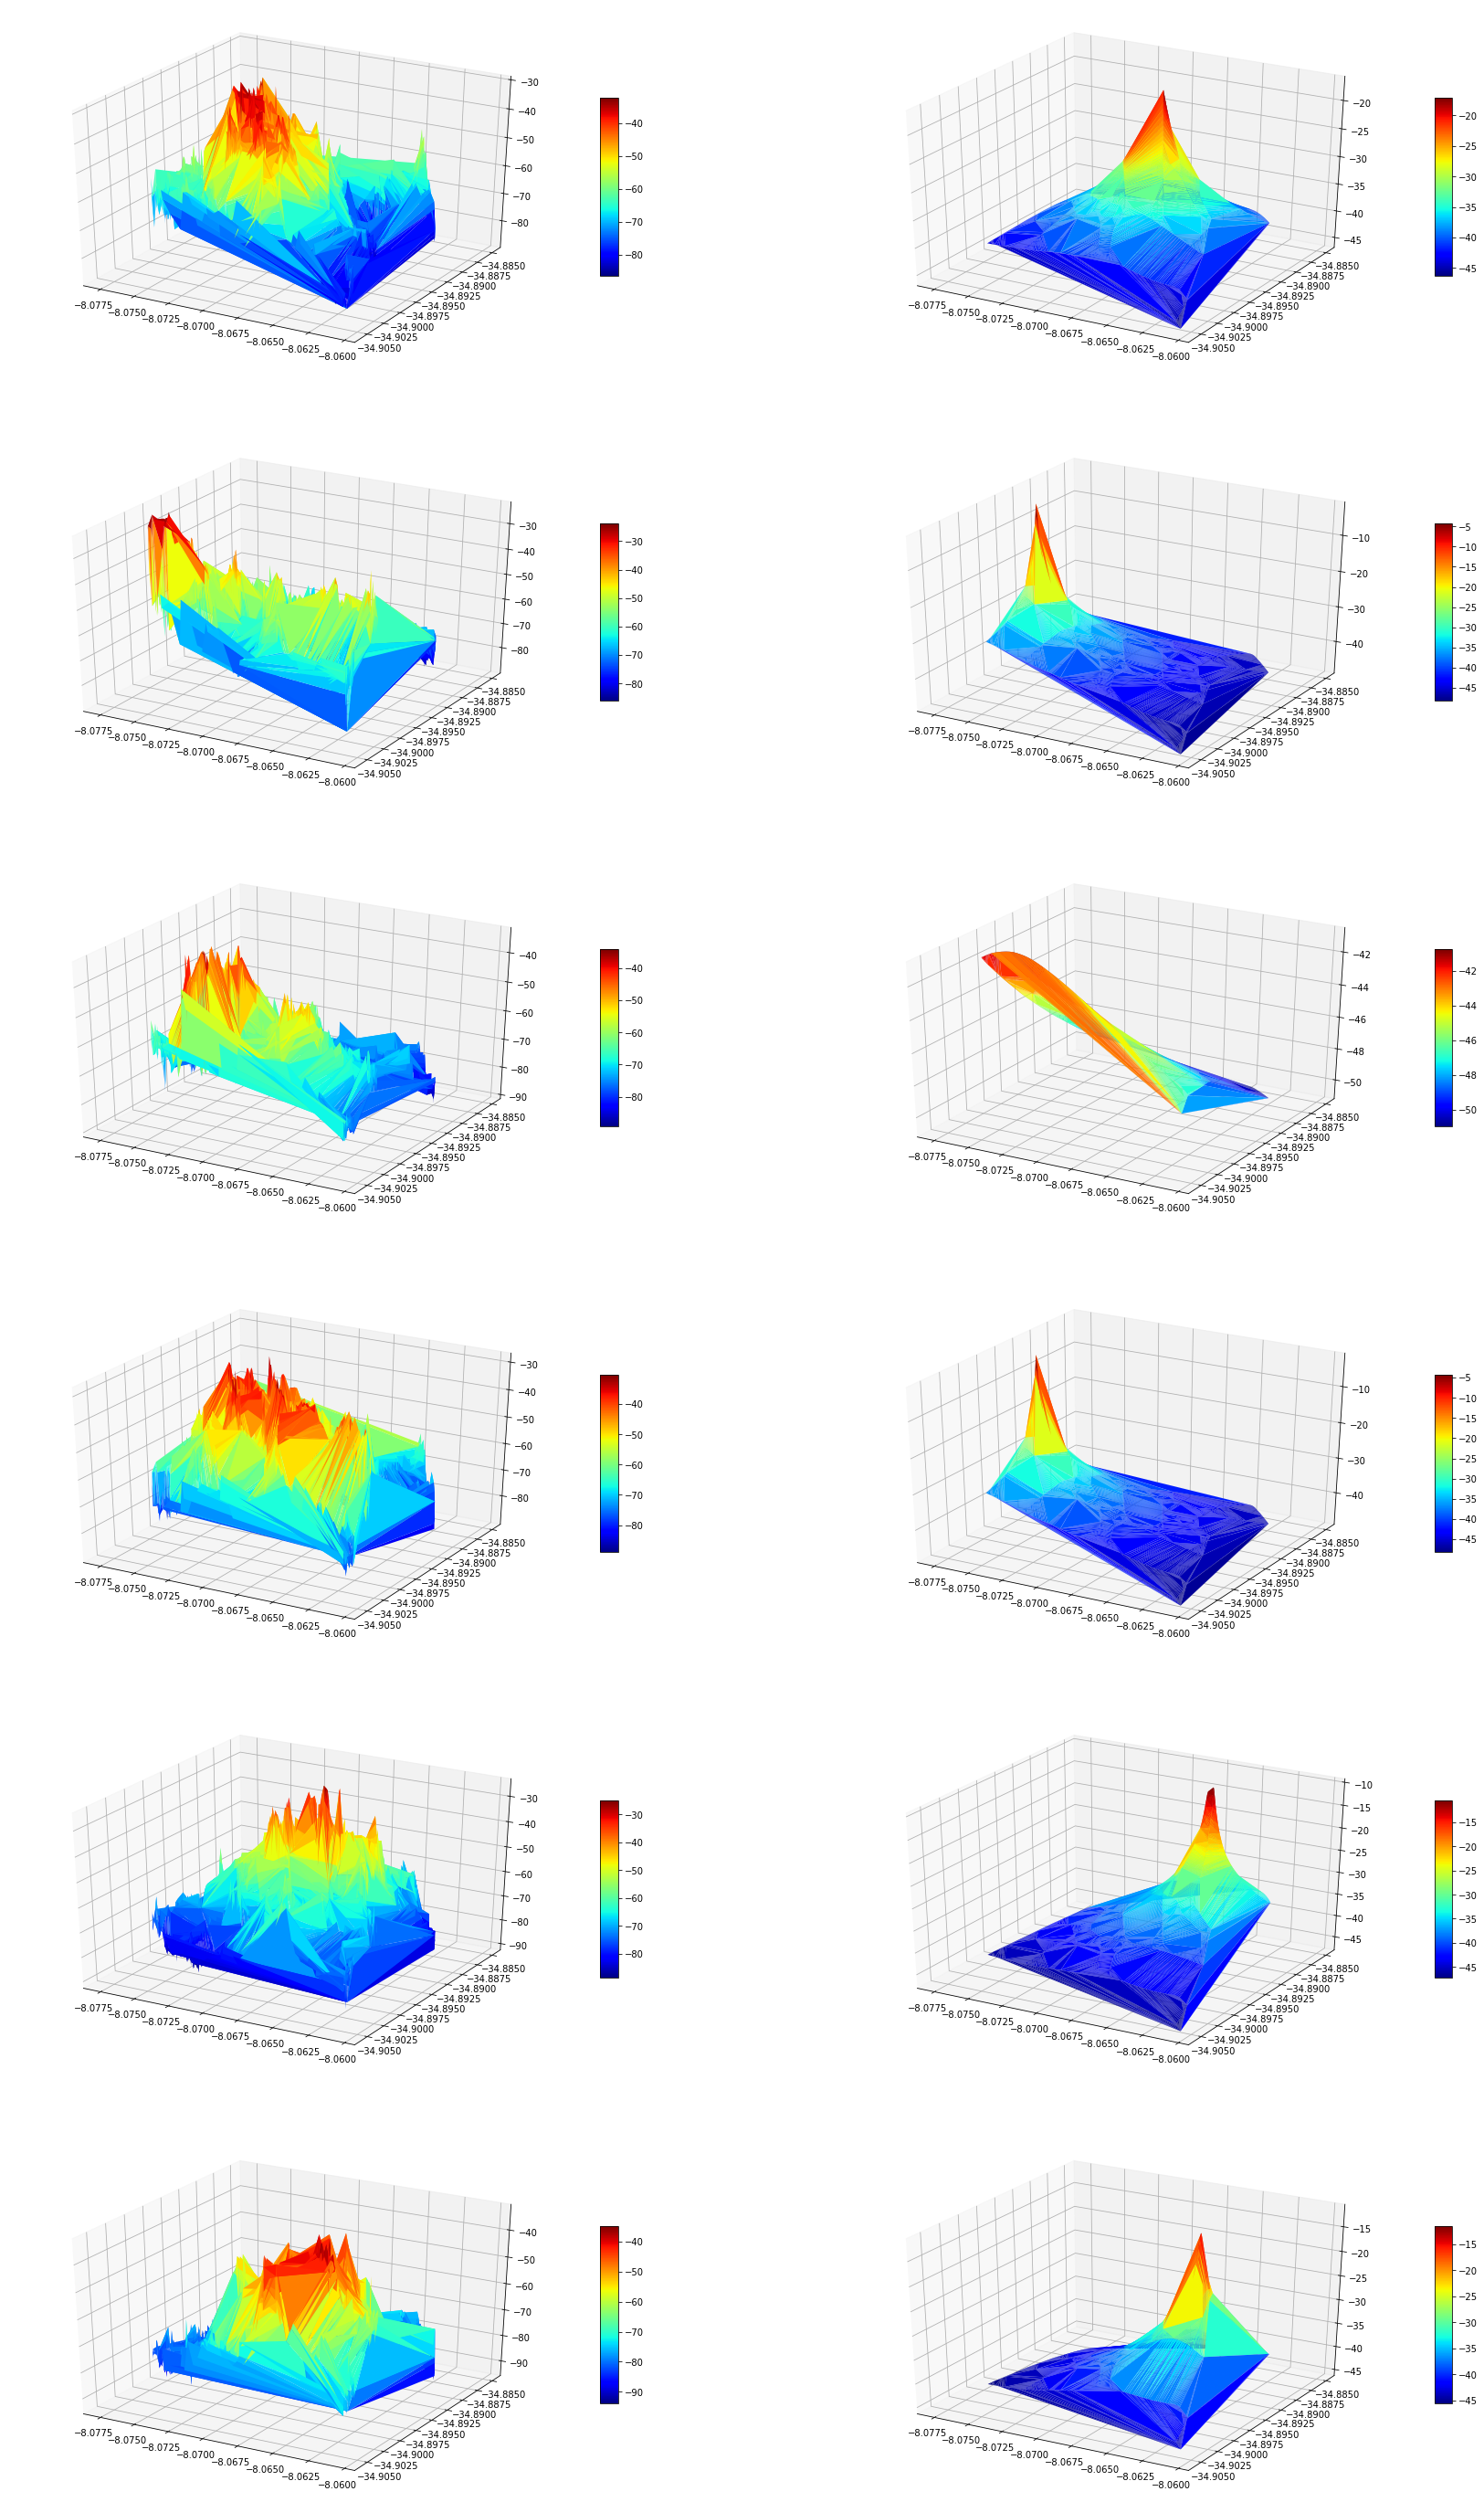

In [43]:
plt.clf() #plt.figaspect(0.5)
fig = plt.figure(figsize=(30,50))
for i in range(1,12,2):
    erbNum = math.ceil(i/2)
    Z = csvMed["RSSI_" +str(erbNum)].values
    ax = fig.add_subplot(6, 2, i, projection='3d')
    surf = ax.plot_trisurf(X,Y,Z,cmap=cm.jet, linewidth=0)
    Z = np.array([55.59 - fsPathLoss(distanciasFS[erbNum][j],1800) for j in range(len(X))])
    fig.colorbar(surf, shrink=0.5, aspect=10)
    
    i = i + 1
    ax = fig.add_subplot(6, 2, i, projection='3d')
    surf2 = ax.plot_trisurf(X,Y,Z,cmap=cm.jet, linewidth=0)
    fig.colorbar(surf2, shrink=0.5, aspect=10)
    
plt.show()
#f, ((r1, p1), (r2, p2),(r3, p3),(r4, p4), (r5, p5),(r6, p6)) = plt.subplots(6, 2, sharex='col', sharey='row')


# Gera Modelo 

In [44]:
#medidas_potencia.values
medidas_posicao_lat = csvMed['lat'].values
medidas_posicao_lon = csvMed['lon'].values

#modela latitude e longitude separadamente
neigh_lat = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
neigh_lat.fit(medidas_potencia,medidas_posicao_lat )

neigh_lon = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
neigh_lon.fit(medidas_potencia,medidas_posicao_lon )

#neigh_lat.predict([-66.825000,-35.600000,-64.875000,-72.575000,-79.525000,-78.450000])
#neigh_lon.predict([-66.825000,-35.600000,-64.875000,-72.575000,-79.525000,-78.450000])
#print(neigh_lat.predict([-67.3, -24.7, -73.4, -67.2, -79.26666666, -80.6]))
#print(neigh_lon.predict([-67.3, -24.7, -73.4, -67.2, -79.26666666, -80.6]))


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

# Pega os Valores de Teste

In [45]:
csvMedTest = pd.read_csv("testLoc.csv")
medidas_posicao_teste = csvMedTest[['lat','lon']].values # Valores em Tupla
medidas_potencia_teste = csvMedTest[["RSSI_1","RSSI_2","RSSI_3","RSSI_4","RSSI_5","RSSI_6"]].values    


In [46]:
np.shape(medidas_posicao_teste)

(200, 2)

# Faz a Predição

In [47]:
predicao_lat = neigh_lat.predict(medidas_potencia_teste)
predicao_lon = neigh_lon.predict(medidas_potencia_teste)

# Calcula o Erro

In [48]:
vet_err_lat = []
vet_err_lon = []
for i in range(0,200):
    vet_err_lat.append(predicao_lat[i] - medidas_posicao_teste[i][0])
    vet_err_lon.append(predicao_lon[i] - medidas_posicao_teste[i][1])

err_geral = []
for i in range(len(predicao_lat)):
    err_geral.append(vincenty((predicao_lat[i],predicao_lon[i]), (medidas_posicao_teste[i][0], medidas_posicao_teste[i][1])).kilometers)



In [53]:
print("MEDIA LAT = " + str(np.mean(vet_err_lat)))
print("MEDIA LON = " + str(np.mean(vet_err_lon)))
print("MEDIA KM = " + str(np.mean(err_geral)))
print("STD = " + str(np.std(err_geral)))


MEDIA LAT = -0.000129606151084
MEDIA LON = 0.000734426809705
MEDIA KM = 0.144464140931
STD = 0.282605214845


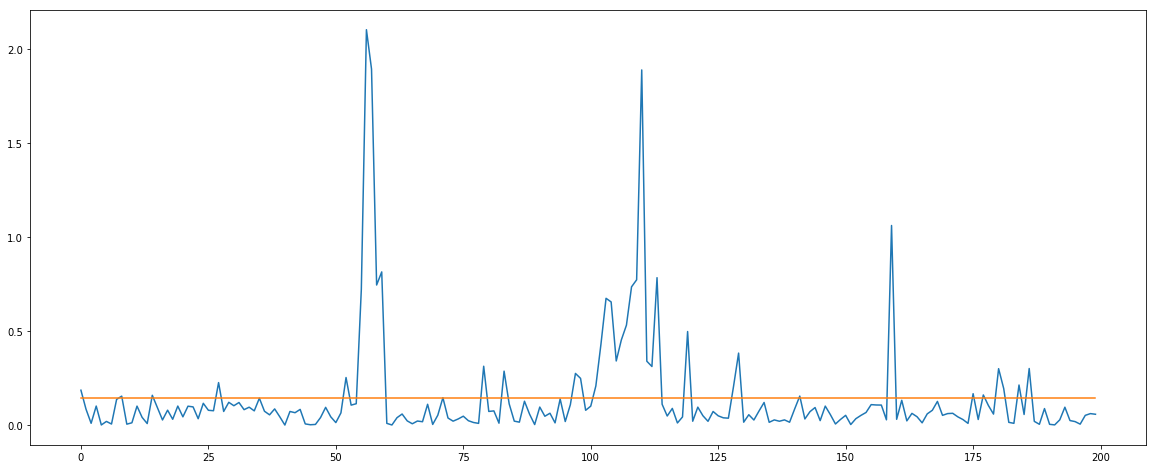

In [56]:
plt.clf
fig = plt.figure(figsize=(20,8))
plt.plot(range(200),err_geral, range(200),[np.mean(err_geral)for i in range(200)])
plt.show()

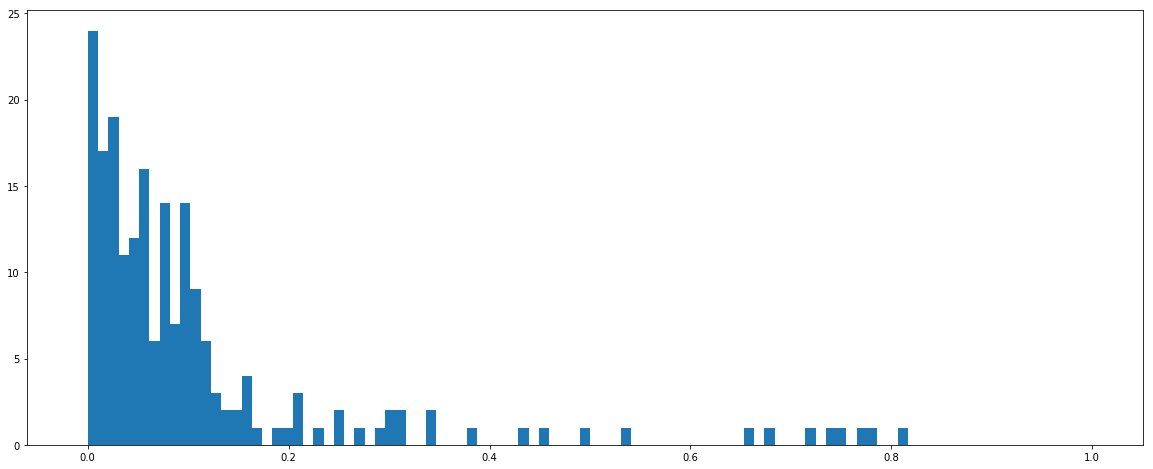

In [57]:
plt.clf
fig = plt.figure(figsize=(20,8))
bins = np.linspace(-0.01, 1, 100)
plt.hist(err_geral,bins)
plt.show()

# Dificuldades

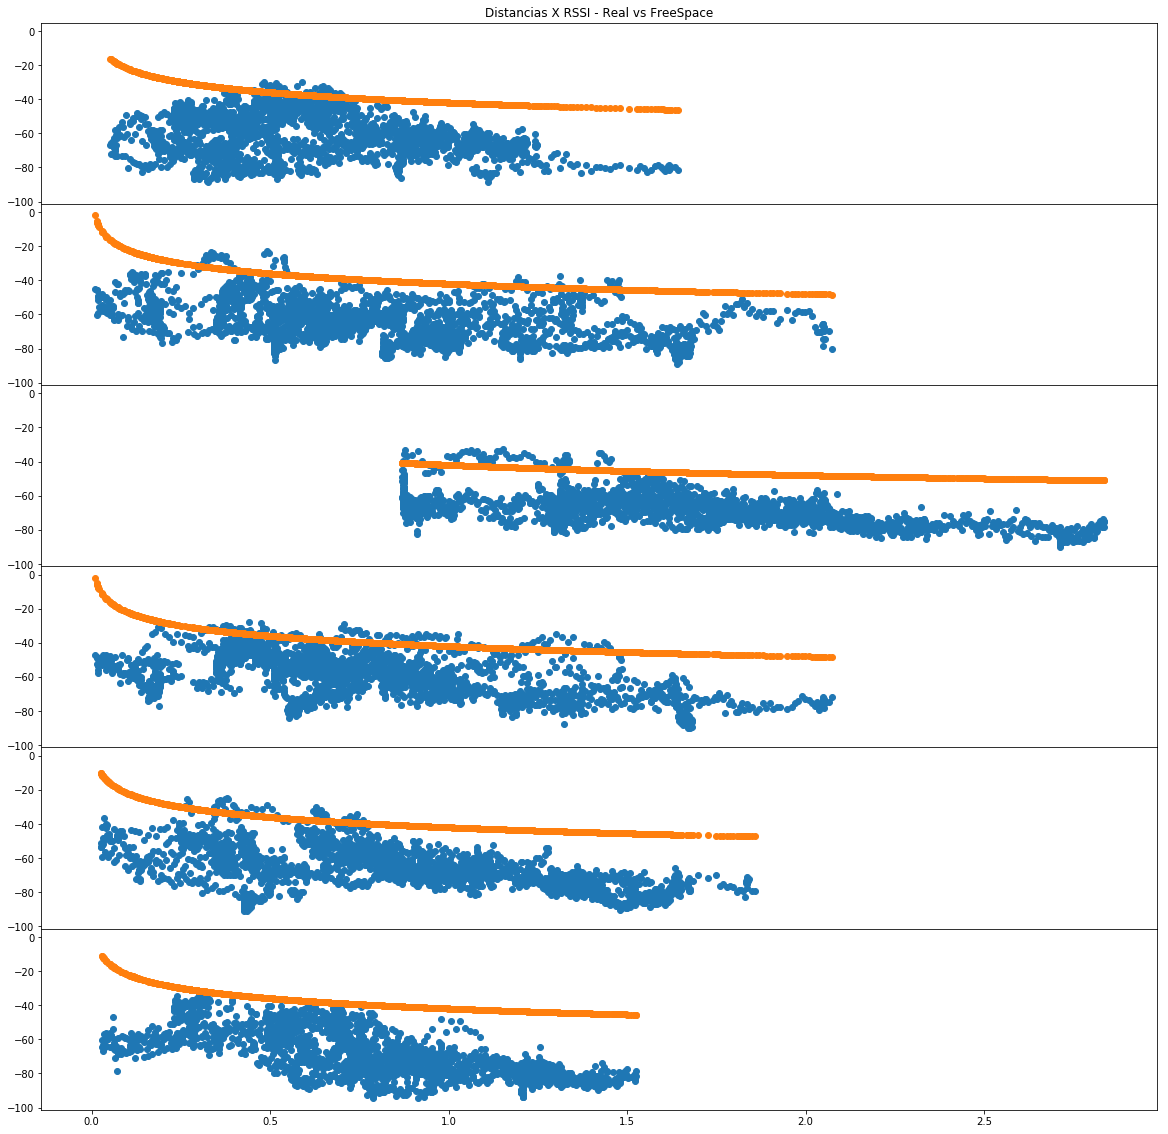

In [52]:
plt.clf() 
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True, sharey=True)
f.set_figheight(20)
f.set_figwidth(20)

plots = list((0,ax1,ax2,ax3,ax4,ax5,ax6))
ax1.set_title('Distancias X RSSI - Real vs FreeSpace')
for i in range(1,7):
    X = distanciasFS[i]
    Z = csvMed["RSSI_"+str(i)].values
    Z1 = np.array([55.59 - fsPathLoss(distanciasFS[i][j],1800) for j in range(len(X))])
    plots[i].scatter(X,Z)
    plots[i].scatter(X,Z1)

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()